# The StanfordExtra dataset

This notebook visualises the capability of the StanfordExtra dataset, which contains 12,000 images of keypoint and segmentations for dogs.

## Accesing the images
For this demo notebook, a subset of 25 images stored in this repo will be used. The full dataset (the 20,580 images from which this dataset is derived) can be accessed here: [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/)

## Understanding the dataset
### Keypoints & Metadata

All of the image data is stored in a single .json file.
 This stores a list of entries, for which each entry is a dictionary of the following information:

- ```img_path``` - The image path within the Stanford Dogs Dataset download.
- ```img_width``` and ```img_height```.
- ```img_bbox``` - Bounding box of dog, in form [x0, y0, width, height]
- ```joints``` - A (24 x 3) array stored as a list of lists. Corresponds to the 24 joints (see joint ref for info on what these joints are). Each joint has its pixel (x, y) position stored, as well as a visibility flag.
- ```ear_tips_labelled``` - A flag to indicate if the tips of both ears have been identified as keypoints for this image.
- ```is_multiple_dogs``` - Flag for multiple dogs (to be removed?)
- ```has_segmentation``` - Flag to confirm segmentation exists for this images
- ```seg``` - Segmentation mask, stored in RLE format

For this dataset, x and y are measured from the top left corner of the image.

## Using the dataset

The script below demonstrates the extraction of key information of the dataset, including keypoints, bounding boxes, and segmentations. It will visualise a sample of 25 dogs included in this repo.

First, load the .json

In [18]:
%matplotlib inline
import json, os
from csv import DictReader
import numpy as np
from matplotlib import pyplot as plt

## Install pycoco to notebook
import sys
!{sys.executable} -m pip install cython
!{sys.executable} -m pip install "git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI"

# define file locations
img_dir = "sample_imgs"
seg_dir = "sample_segs"
def_file = "keypoint_definitions.csv"

json_loc = "sample_stanford_extra.json"
with open(json_loc) as infile:
    json_data = json.load(infile)

# convert json data to a dictionary of img_path : all_data, for easy lookup
json_dict = {i['img_path']: i for i in json_data}

# load keypoint labels and colours
with open(def_file) as infile:
    reader = DictReader(infile)
    colours = ["#"+row['Hex colour'] for row in reader]
    labels = [row['Name'] for row in reader]

First, we have to define the functions necessary for loading RLE formats. This can be done using the pycocotools Python API (link).

In [19]:
from pycocotools.mask import decode as decode_RLE

def get_seg_from_entry(entry):
    """Given a .json entry, returns the binary mask as a numpy array"""

    rle = {
        "size": [entry['img_height'], entry['img_width']],
        "counts": entry['seg']
    }

    decoded = decode_RLE(rle)
    return decoded

Next, a function ```get_dog``` will be defined, which takes the name of a dog, and loads in all the relevant information as a dict

In [20]:
def get_dog(name):

    data = json_dict[name]

    img_data = plt.imread(os.path.join(img_dir, data['img_path']))   # load img

    # load seg
    seg_data = get_seg_from_entry(data)

    # add to output
    data['img_data'] = img_data
    data['seg_data'] = seg_data

    return data

Now, the next code block selects a random set of 4 samples, and plots them below


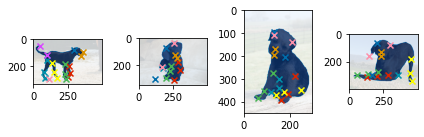

In [21]:
# get list of all available sample files
samples = []
for folder in os.listdir(img_dir):
    for file in os.listdir(os.path.join(img_dir, folder)):
        samples.append(f"{folder}/{file}")

# select 4 samples
n_samples = 4
selected_samples = np.random.choice(samples, n_samples, replace=False)

# plot these on 3 axes
fig, axes = plt.subplots(ncols = n_samples)
for ax, sample in zip(axes, selected_samples):
    data = get_dog(sample)
    ax.imshow(data['img_data'])
    ax.imshow(data['seg_data'], cmap="Blues", alpha = 0.8)

    # plot keypoints
    for idx, (x, y, v) in enumerate(data['joints']):
        if v == 0:
            continue # ignore any invisible keypoints

        ax.scatter([x], [y], c=[colours[idx]], marker="x")


plt.tight_layout()
plt.show()